In [1]:
#!python forward_mocks_all.py --type ELG_LOPnotqso --survey_version v0.6 --nran 15 --mockid 5

In [2]:
#!python forward_mocks.py --mockid 10 --type QSO --survey_version v0.6 --nran 15

In [3]:
#!python cont_mocks.py --mockid 10 --type QSO

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
import fitsio
from astropy.table import Table, vstack
import numpy as np
from pypower import CatalogFFTPower,PowerSpectrumStatistics,setup_logging
from pycorr import TwoPointCorrelationFunction
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#setup_logging()

In [6]:
c1fn = '/global/cfs/cdirs/desi/cosmosim/KP45/MC/Clustering/EZmock/CubicBox/LRG/Pk/jmena/nmesh_512/pypower_format/Pk_EZmock_B2000G512Z0.8N8015724_b0.385d4r169c0.3_seed999.npy'
c2fn = '/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.1/blinded/pk/covariances/cov_gaussian_prerec_LRG_NGC_0.4_0.6.txt'
c1 = np.load(c1fn,allow_pickle=True).item()
c2 = np.loadtxt(c2fn)

In [21]:
len(c1['wedges']['modes'])#['attrs']


2

In [5]:
tps = [f'{t}_complete_gtlimaging' for t in ['ELG_LOP','LRG']]#,'QSO']]
tp = 'ELG_LOP_complete_gtlimaging'
mockid = 10
mockdir = f"/pscratch/sd/a/arosado/SecondGenMocks/AbacusSummit/mock{mockid}"

survey_dir = f"/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/"
wts = ['default_FKP']#, 'default']

# redshift bins tracer was trained on
#if tp[:3] == 'ELG':
#    zrl = [(0.8,1.1),(1.1,1.6)]
#if tp[:3] == 'QSO':
#    zrl = [(0.8,1.3),(1.3,2.1)]# mocks do not have ,(2.1,3.5)] 
#if tp[:3] == 'LRG':
#    zrl = [(0.4,0.6),(0.6,0.8),(0.8,1.1)]  
#if tp[:3] == 'BGS':
#    zrl = [(0.1,0.4)]
#zl = zrl[0]
#zw = str(zl[0])+'_'+str(zl[1])
#zmin,zmax = zl[0],zl[1]
#print(tp,zw)

mock_wts = ['default', 'default_cont']
labels = [f"data"]
mocklabels =[f"mock{mockid}",f"mock{mockid}+cont"]
markers = [None, None, None, None]
regions = ['NGC','SGC','GCcomb']
mockls = ['--',':']
ls = ['-']
nran = 4

In [6]:
#!ls -l /global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/pk/

In [7]:
plot_dir = "plots/v0.6/pk"
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)
    print(f"created dir: {plot_dir}")
    
xiplot_dir = "plots/v0.6/xi"
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)
    print(f"created dir: {plot_dir}")

# Pk

ELG_LOP_complete_gtlimaging 0.8_1.1


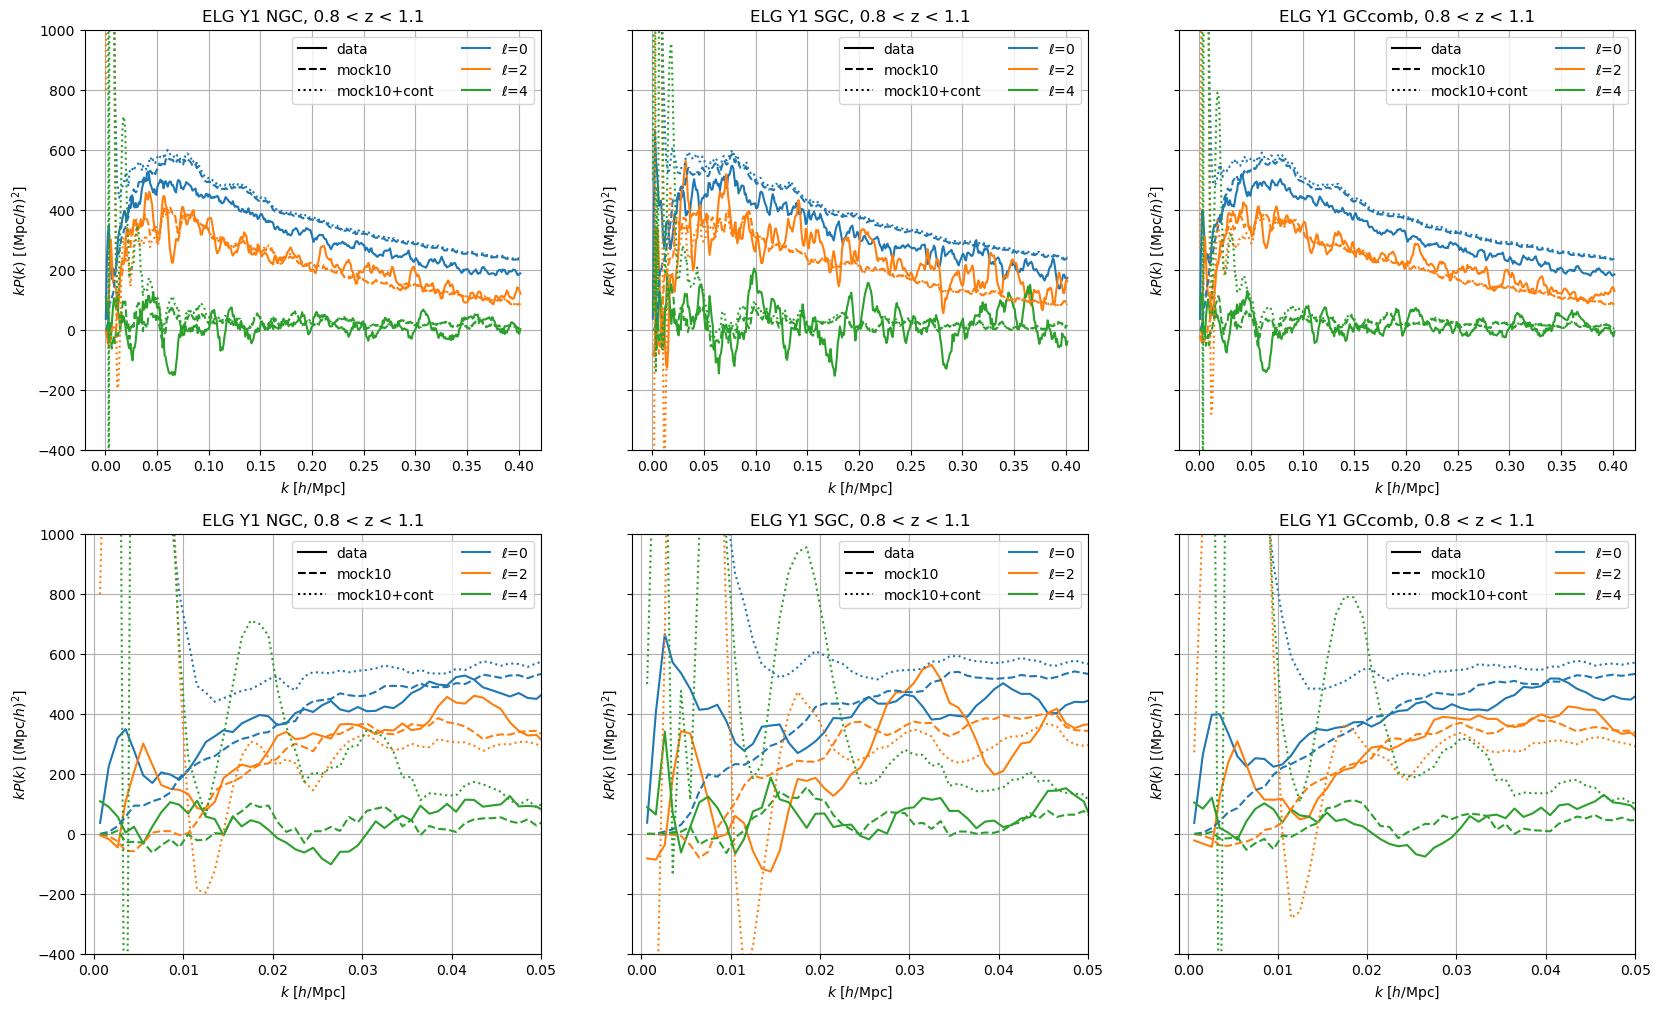



ELG_LOP_complete_gtlimaging 1.1_1.6


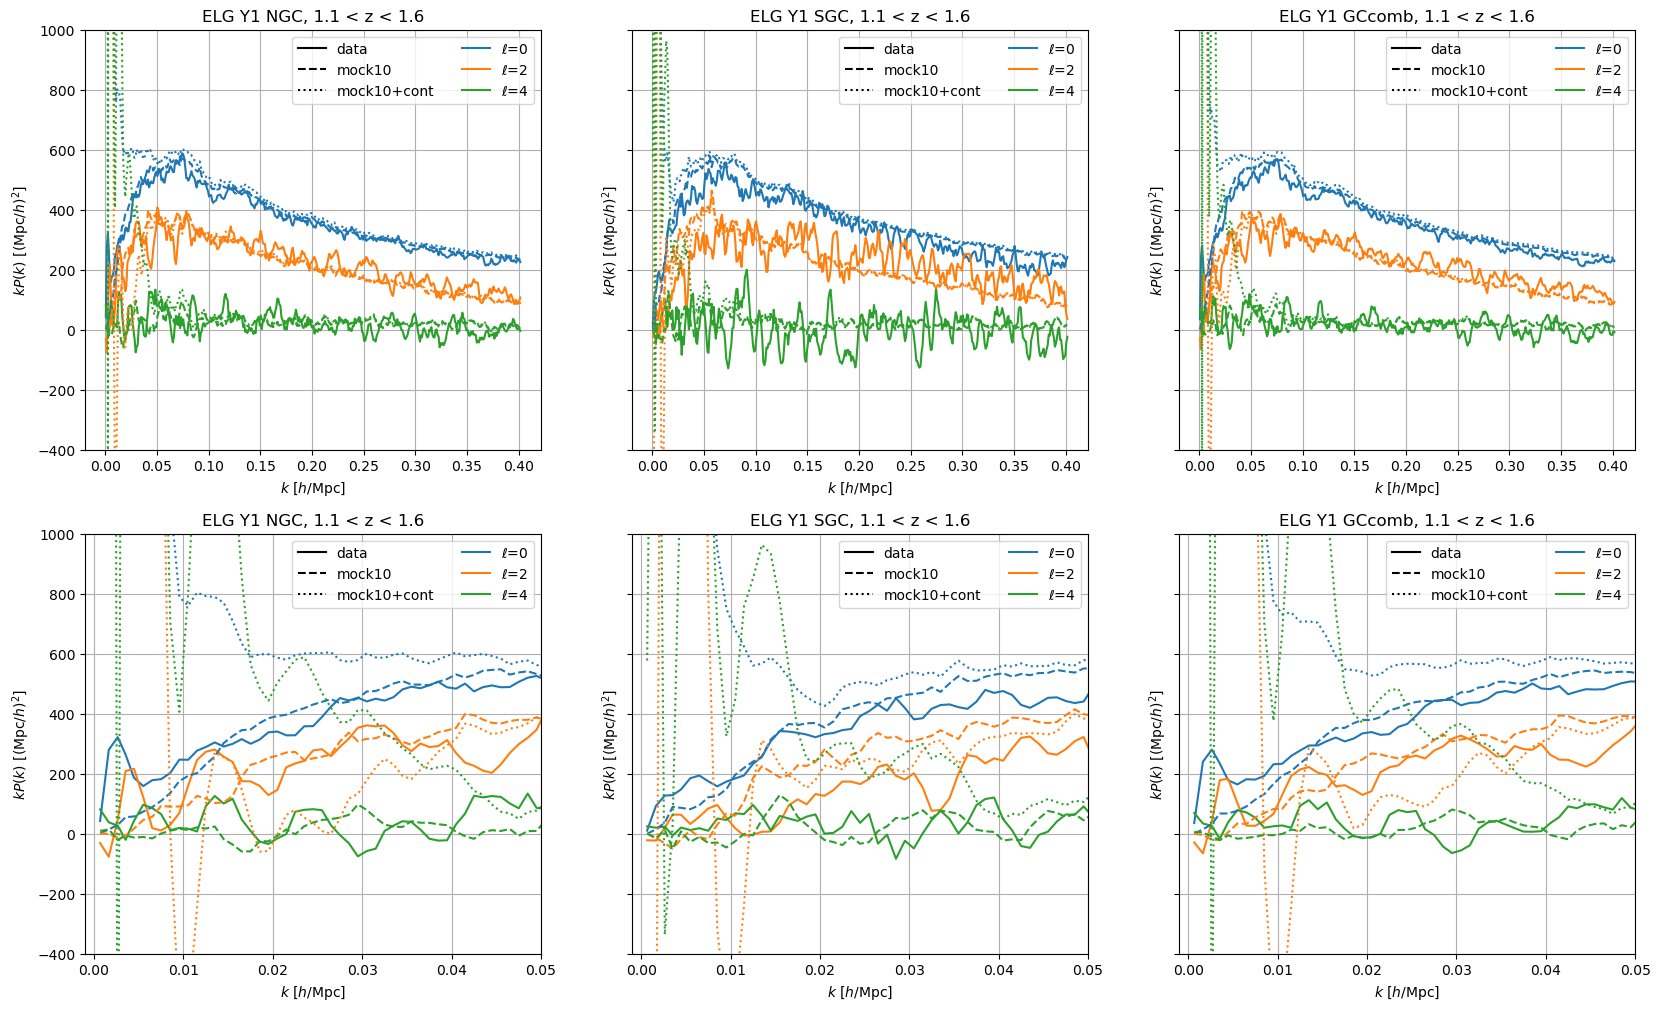



LRG_complete_gtlimaging 0.4_0.6


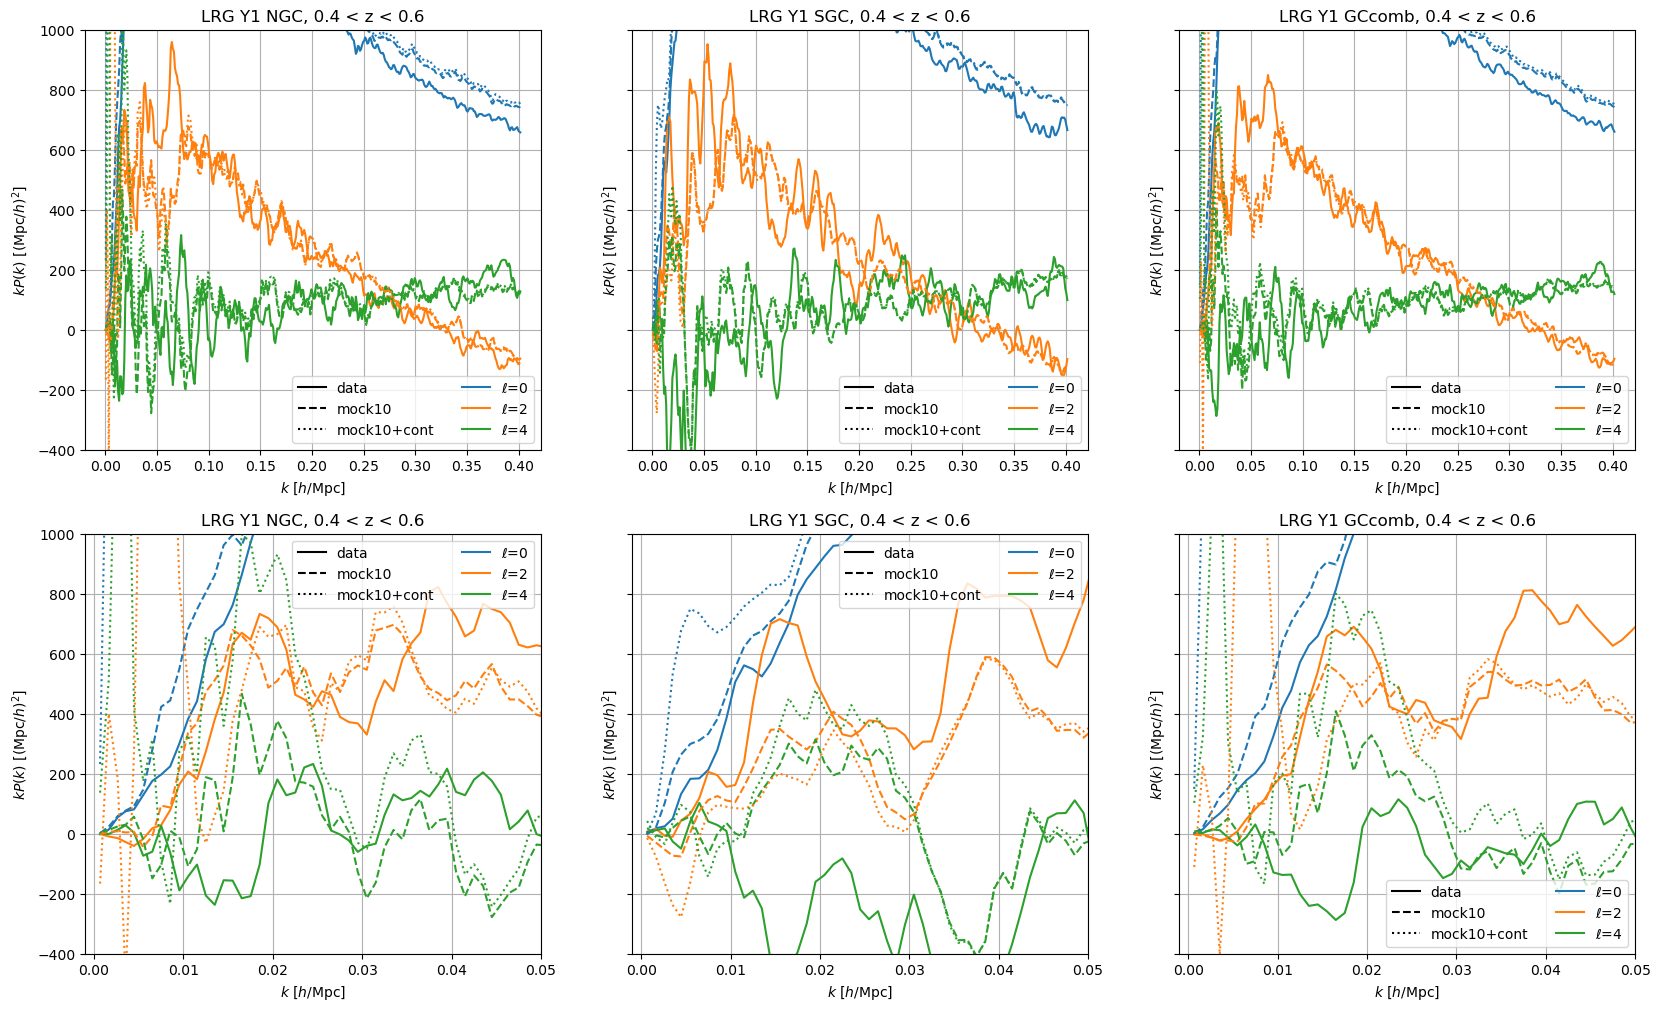



LRG_complete_gtlimaging 0.6_0.8


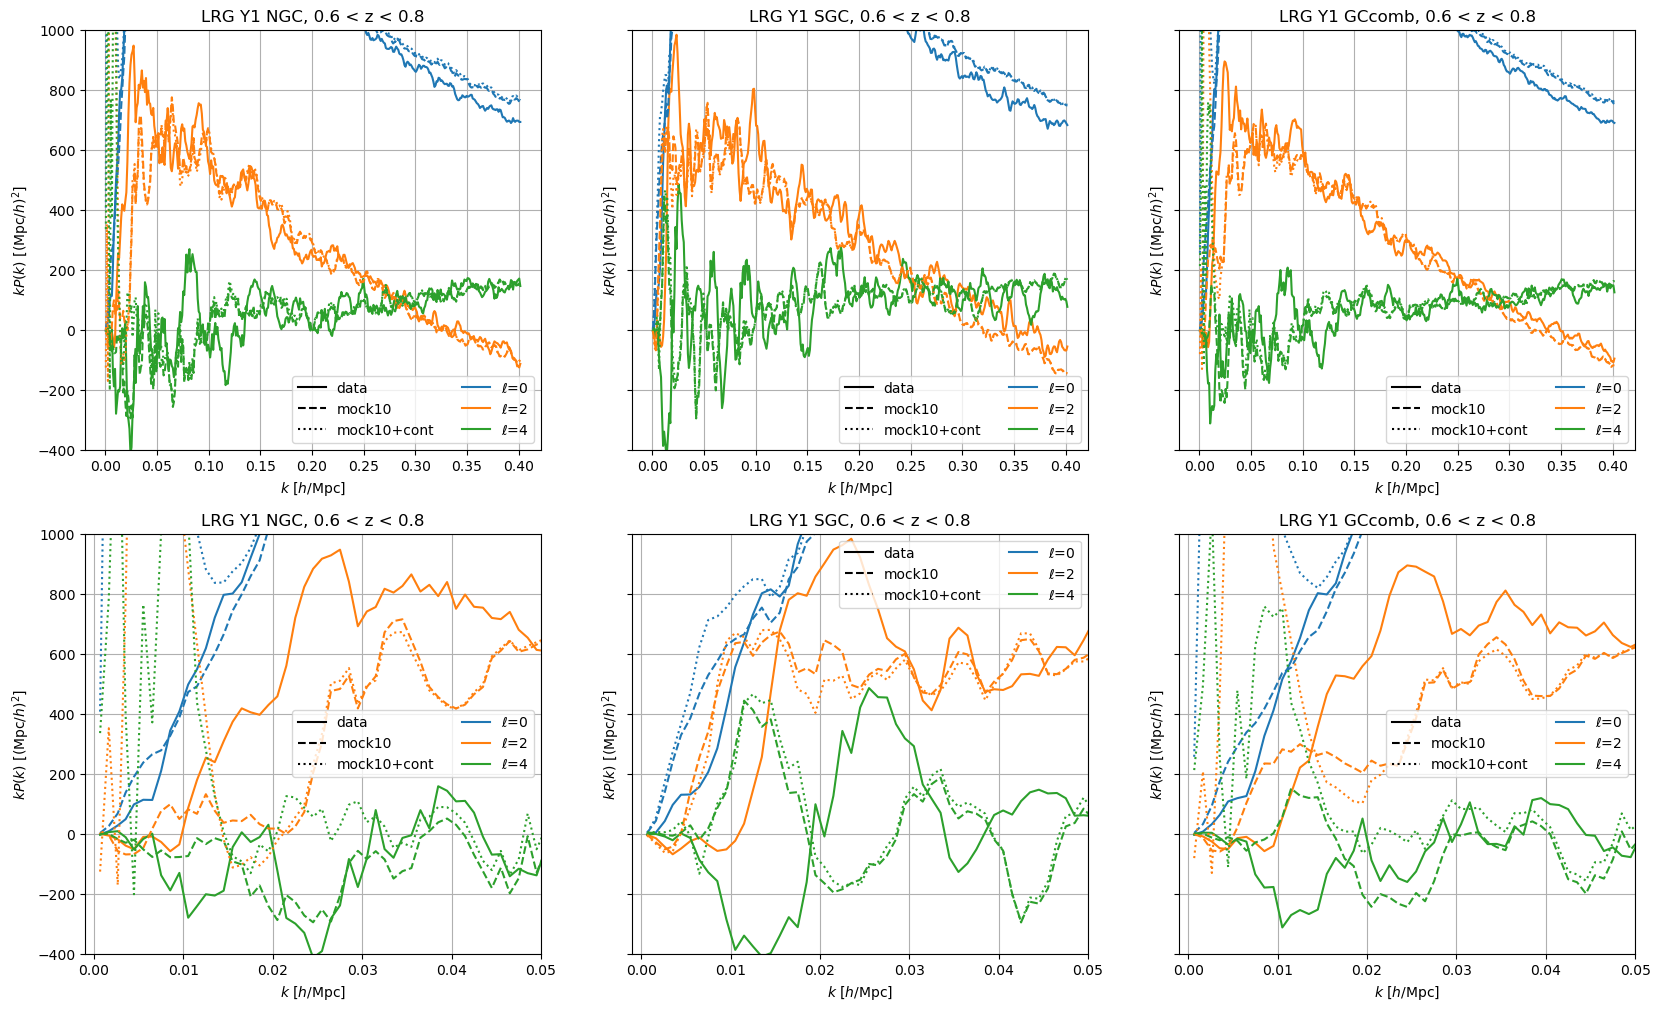



LRG_complete_gtlimaging 0.8_1.1


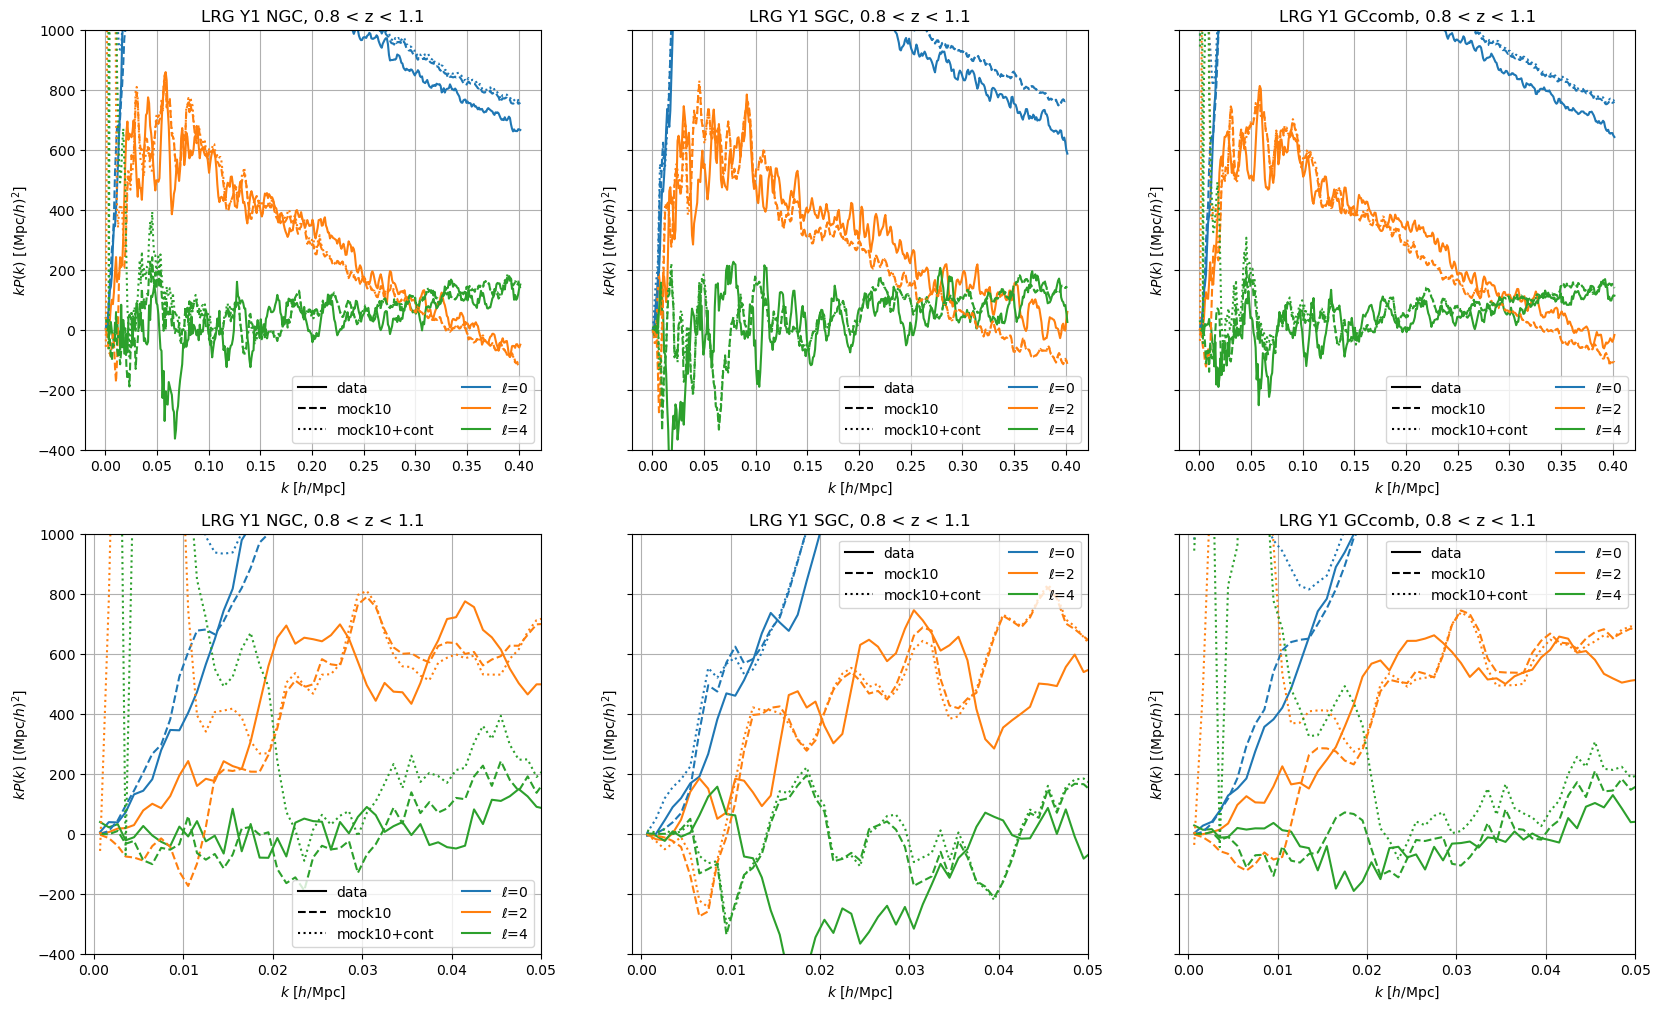

In [6]:
for tp in tps:
    # redshift bins tracer was trained on
    if tp[:3] == 'ELG':
        zrl = [(0.8,1.1),(1.1,1.6)]
    if tp[:3] == 'QSO':
        zrl = [(0.8,1.3),(1.3,2.1)]# mocks do not have ,(2.1,3.5)] 
    if tp[:3] == 'LRG':
        zrl = [(0.4,0.6),(0.6,0.8),(0.8,1.1)]  
    if tp[:3] == 'BGS':
        zrl = [(0.1,0.4)]
        
    pp = PdfPages(plot_dir+f'/pk_{tp[:3]}_mock{mockid}.pdf')
    for zl in zrl:
        zw = str(zl[0])+'_'+str(zl[1])
        zmin,zmax = zl[0],zl[1]
        print(tp,zw)
        fig,lax = plt.subplots(ncols=3,nrows=2,sharex=False,sharey=True,figsize=(20,12))
        #fig.subplots_adjust(hspace=0.3,wspace=0.2)
        ax = lax.flatten()

        for iax, reg in enumerate(regions):
            for ind in [0,1]:
                iax = iax + 3*ind
                # plot pk for data
                for i, wt in enumerate(wts):
                    if tp[:3] == 'ELG': tp_ = 'ELG_LOPnotqso'
                    else: tp_ = tp[:3]
                    pkdir = os.path.join(survey_dir,'pk')
                    pkfn = os.path.join(pkdir, f"pkpoles_{tp_}_{reg}_{zw}_{wt}_lin.npy")
                    result = PowerSpectrumStatistics.load(pkfn)
                    k,poles =result(return_k=True, complex=False)
                    for ic,pole in enumerate(poles):
                        ax[iax].plot(k, k*pole, ls=ls[i], c=f"C{ic}", marker=markers[i])

                # plot pk for mock
                for i, mock_wt in enumerate(mock_wts):
                    mock_pkdir = os.path.join(mockdir,'pk')
                    mock_pkfn = os.path.join(mock_pkdir, f"pkpoles_{tp}_{reg}_{zw}_{mock_wt}_lin.npy")
                    #print(mock_pkfn)
                    result = PowerSpectrumStatistics.load(mock_pkfn)
                    k,poles =result(return_k=True, complex=False)
                    for ic,pole in enumerate(poles):
                        ax[iax].plot(k, k*pole, ls=mockls[i], c=f"C{ic}", marker=markers[i])

                for i,wt in enumerate(wts):
                    ax[iax].plot([],[],ls=ls[i], c='k',label=labels[i], marker=markers[i])
                for i,wt in enumerate(mock_wts):
                    ax[iax].plot([],[],ls=mockls[i], c='k',label=mocklabels[i], marker=markers[i])
                for i,ell in enumerate([0,2,4]):
                    ax[iax].plot([],[],ls='-', c=f'C{i}', label=f"$\ell$={ell}")
                ax[iax].grid(True)
                ax[iax].set_title(f"{tp[:3]} Y1 {reg}, {zmin} < z < {zmax}")
                ax[iax].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
                ax[iax].set_ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
                ax[iax].set_ylim((-400,1000))
                ax[iax].legend(ncol=2)
                if iax>=3: ax[iax].set_xlim((-0.001,0.05))

        pp.savefig()
        plt.show()
        print('\n')
    pp.close()

# Correlation function

In [23]:
20/12, (20/12) * 8

(1.6666666666666667, 13.333333333333334)

ELG_LOP_complete_gtlimaging 0.8_1.1
ELG_LOP_complete_gtlimaging 1.1_1.6


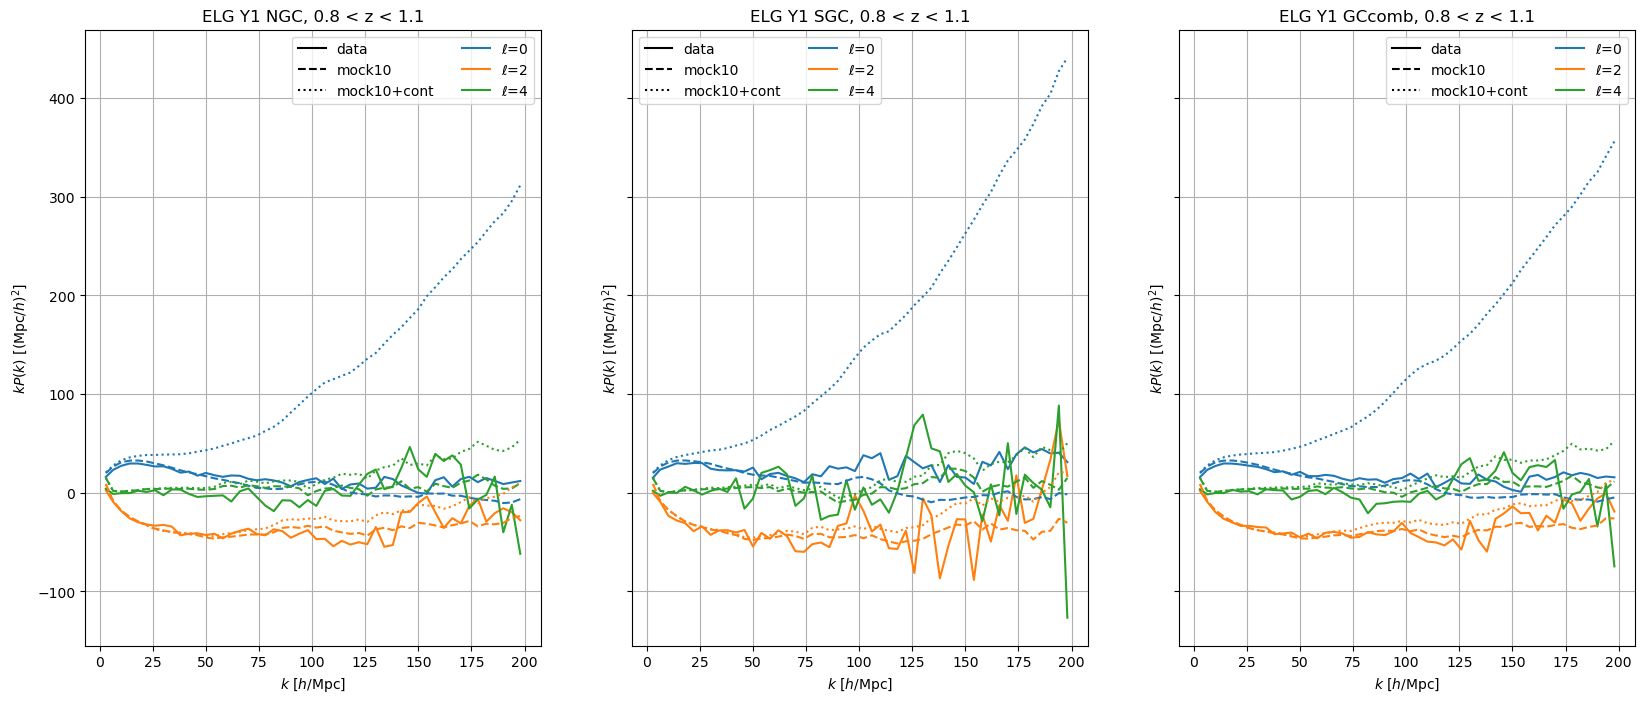

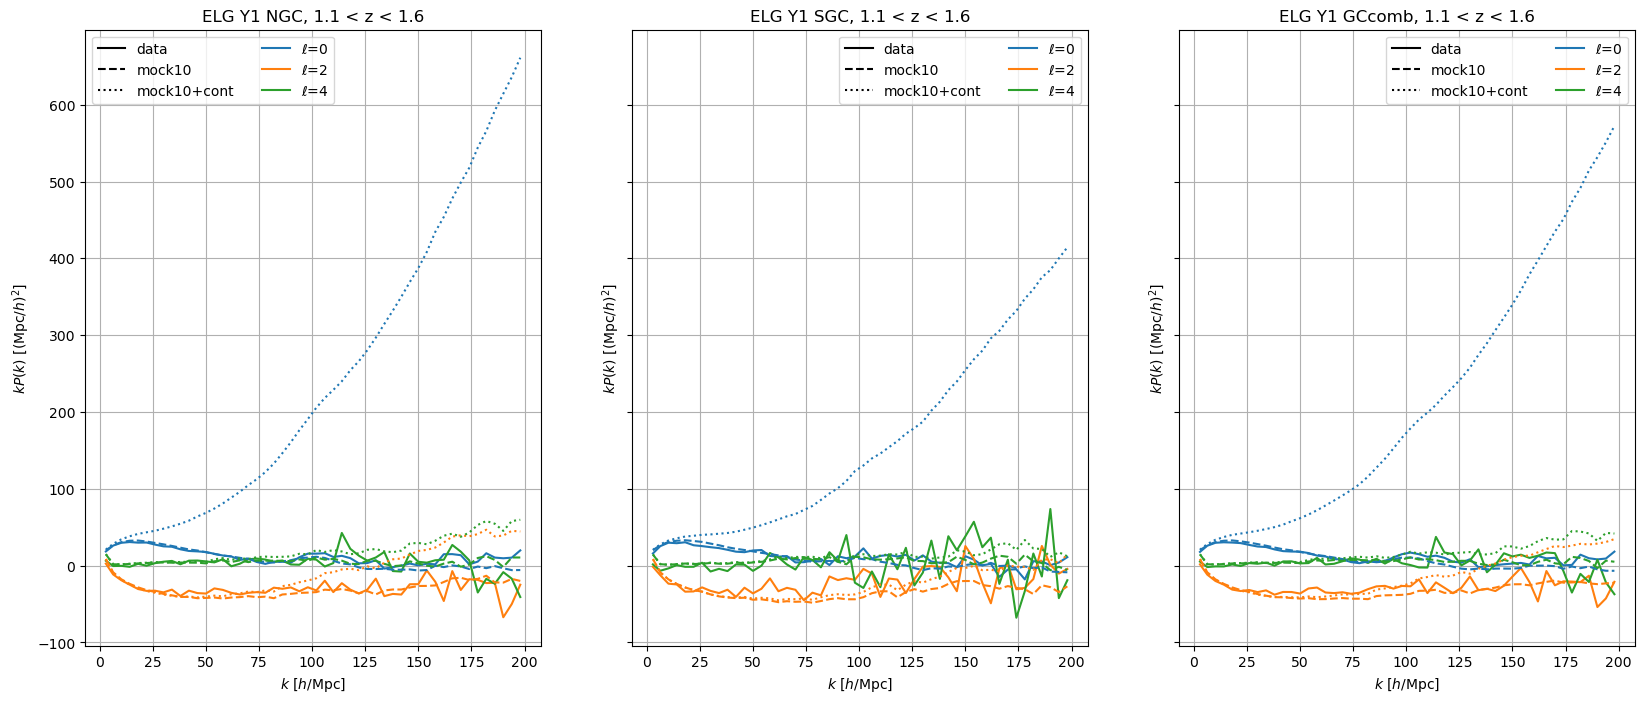



LRG_complete_gtlimaging 0.4_0.6
LRG_complete_gtlimaging 0.6_0.8
LRG_complete_gtlimaging 0.8_1.1


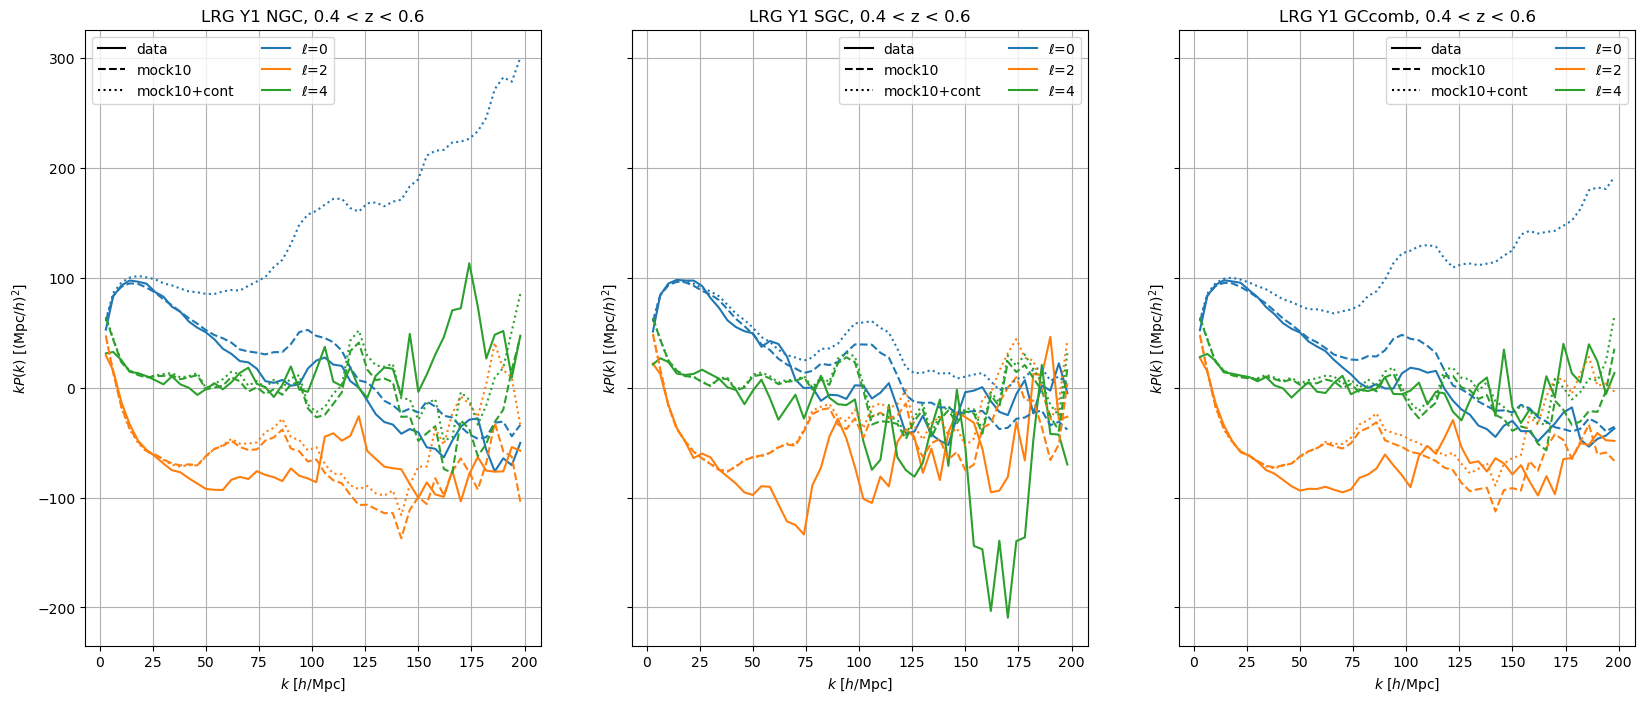

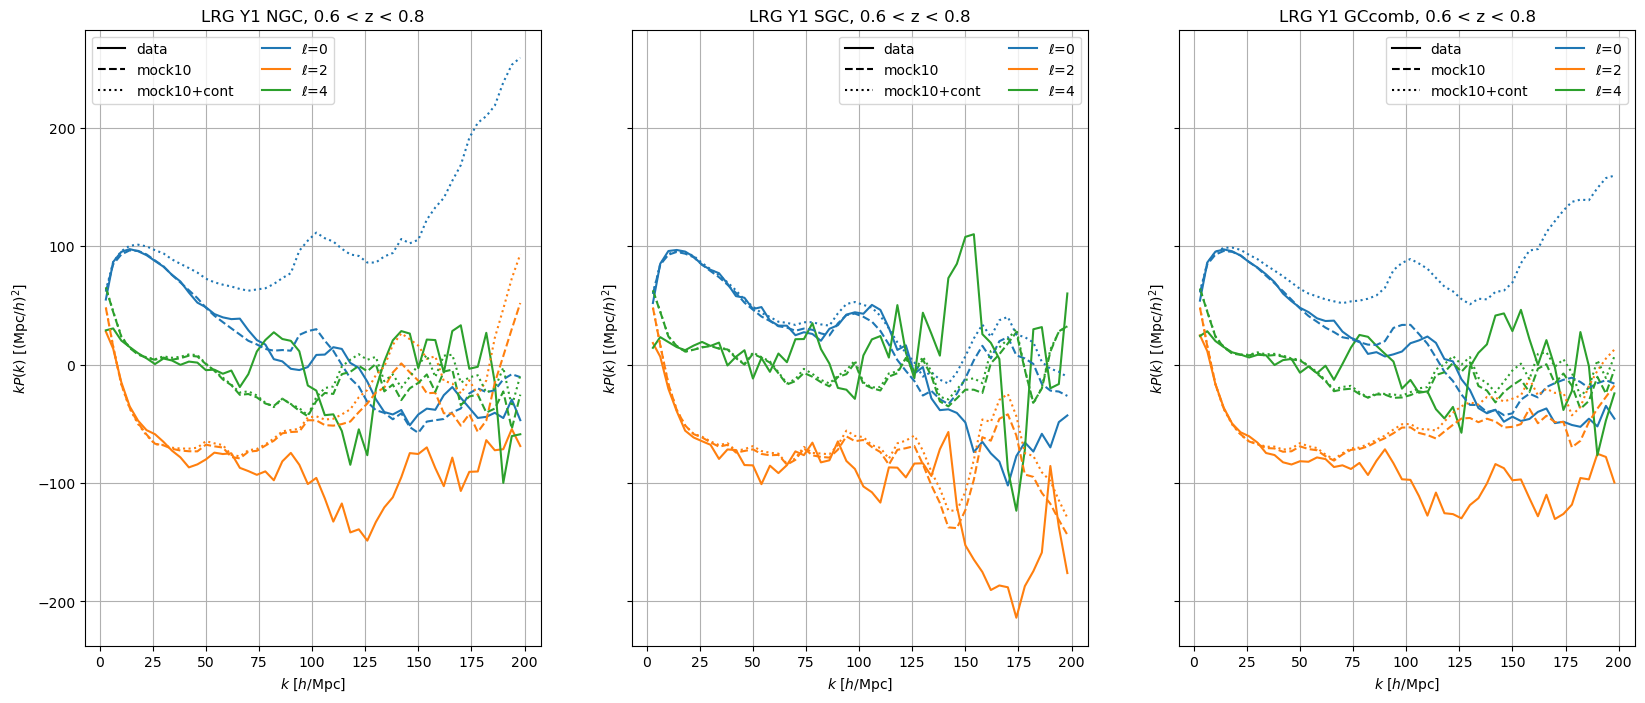

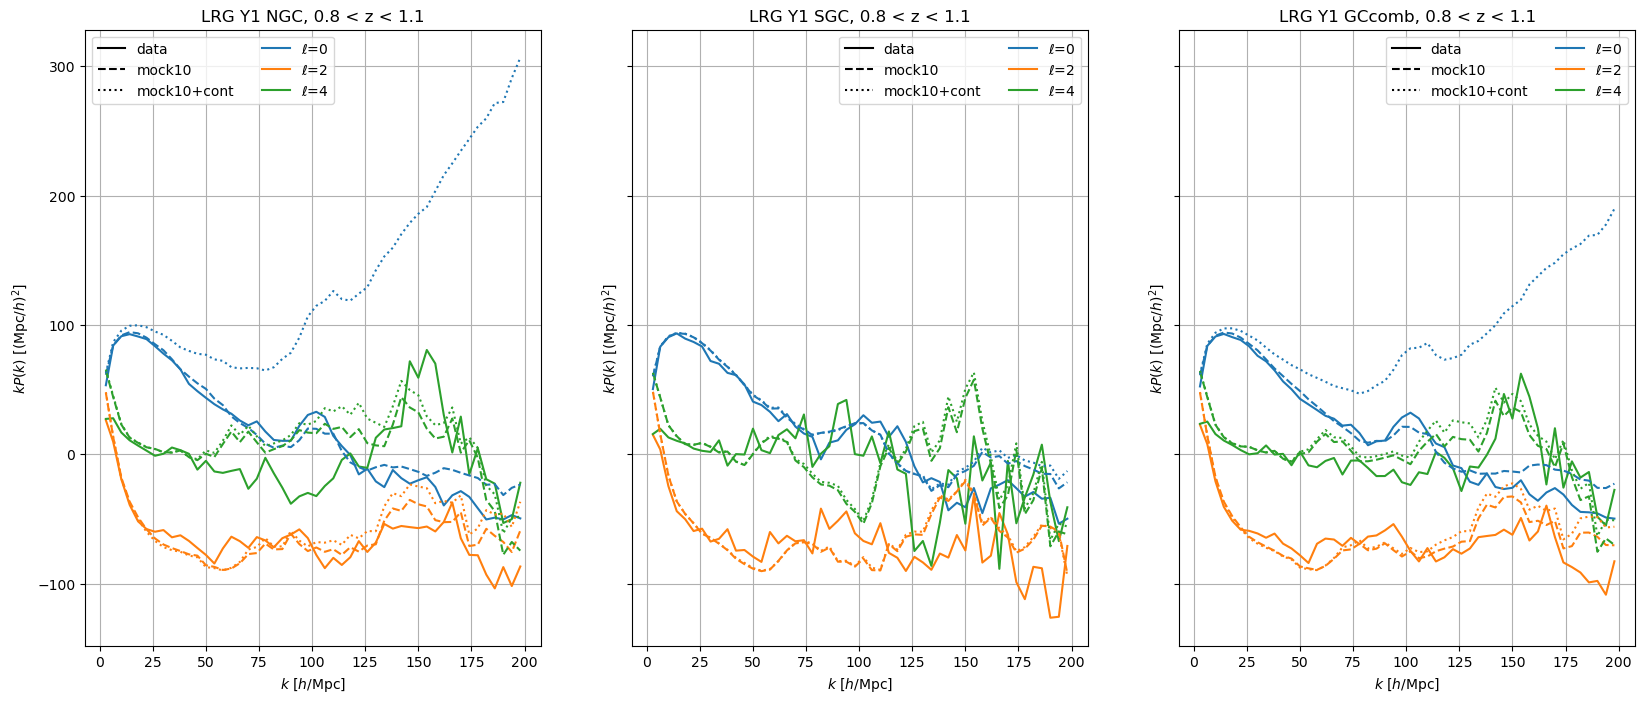

In [30]:
rebin  = True
factor = 4
for tp in tps:
    # redshift bins tracer was trained on
    if tp[:3] == 'ELG':
        zrl = [(0.8,1.1),(1.1,1.6)]
    if tp[:3] == 'QSO':
        zrl = [(0.8,1.3),(1.3,2.1)]# mocks do not have ,(2.1,3.5)] 
    if tp[:3] == 'LRG':
        zrl = [(0.4,0.6),(0.6,0.8),(0.8,1.1)]  
    if tp[:3] == 'BGS':
        zrl = [(0.1,0.4)]
        
    pp = PdfPages(plot_dir+f'/xi_{tp[:3]}_mock{mockid}.pdf')
    for zl in zrl:
        zw = str(zl[0])+'_'+str(zl[1])
        zmin,zmax = zl[0],zl[1]
        print(tp,zw)
        fig,lax = plt.subplots(ncols=3,nrows=1,sharex=False,sharey=True,figsize=(20,8))
        #fig.subplots_adjust(hspace=0.3,wspace=0.2)
        ax = lax.flatten()

        for iax, reg in enumerate(regions):
            # plot xi for data
            for i, wt in enumerate(wts):
                if tp[:3] == 'ELG': tp_ = 'ELG_LOPnotqso'
                else: tp_ = tp[:3]
                xi_dir = os.path.join(survey_dir,'xi','smu')
                xi_fn = os.path.join(xi_dir, f"allcounts_{tp_}_{reg}_{zw}_{wt}_lin_njack0_nran{nran}_split20.npy")
                #print(xi_fn)
                result = TwoPointCorrelationFunction.load(xi_fn)
                if rebin:
                    rebinned = result[:(result.shape[0] // factor) * factor:factor]
                sep, xis = rebinned(ells=(0, 2, 4), return_sep=True, return_std=False)
                for ic,xi in enumerate(xis):
                    ax[iax].plot(sep, sep**2*xi, ls=ls[i], c=f"C{ic}",marker=markers[i])

            # plot xi for mock
            for i, mock_wt in enumerate(mock_wts):
                mock_xidir = os.path.join(mockdir, 'smu')
                mock_xifn = os.path.join(mock_xidir, f"allcounts_{tp}_{reg}_{zw}_{mock_wt}_lin_njack0_nran{nran}_split20.npy")
                #print(xi_fn)
                result = TwoPointCorrelationFunction.load(mock_xifn)
                if rebin:
                    rebinned = result[:(result.shape[0] // factor) * factor:factor]
                sep, xis = rebinned(ells=(0, 2, 4), return_sep=True, return_std=False)
                for ic,xi in enumerate(xis):
                    ax[iax].plot(sep, sep**2*xi, ls=mockls[i], c=f"C{ic}",marker=markers[i])

            for i,wt in enumerate(wts):
                ax[iax].plot([],[],ls=ls[i], c='k',label=labels[i], marker=markers[i])
            for i,wt in enumerate(mock_wts):
                ax[iax].plot([],[],ls=mockls[i], c='k',label=mocklabels[i], marker=markers[i])
            for i,ell in enumerate([0,2,4]):
                ax[iax].plot([],[],ls='-', c=f'C{i}', label=f"$\ell$={ell}")
            ax[iax].grid(True)
            ax[iax].set_title(f"{tp[:3]} Y1 {reg}, {zmin} < z < {zmax}")
            ax[iax].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
            ax[iax].set_ylabel(r'$kP(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
            #ax[iax].set_ylim((-400,1000))
            ax[iax].legend(ncol=2)
        pp.savefig()
    plt.show()
    print('\n')
    pp.close()

In [ ]:

rebin=True
factor = 4
for reg in regions:
    ax = plt.gca()
    ells = [0]#,2,4]
    for i, wt in enumerate(wts):
        for index, ell in enumerate(ells):
            xi_dir = os.path.join(base_dir, 'smu')
            xi_fn = os.path.join(xi_dir, f"allcounts_ELG_LOPnotqso_{reg}_{zmin}_{zmax}_{wt}_lin_njack0_nran{nran}_split20.npy")
            #print(xi_fn)
            result = TwoPointCorrelationFunction.load(xi_fn)
            if rebin:
                rebinned = result[:(result.shape[0] // factor) * factor:factor]
            sep, xis = rebinned(ells=(0, 2, 4), return_sep=True, return_std=False)
            for ic,xi in enumerate(xis):
                ax.plot(sep, sep**2*xi, ls=ls[i], c=f"C{ic}",marker=markers[i])#, label=f"{wt}")
                #ax.plot(sep, sep**2*xi, ls=ls[i], c=f"C{ic}")#, label=f"{wt}")
    for i,wt in enumerate(labels):
        if i!=0:
            ax.plot([],[],ls=ls[i], c='k',label=wt, marker=markers[i])#+r', $\Delta$EBV_RZ')
        else:
            ax.plot([],[],ls=ls[i], c='k',label=wt)
    for i,ell in enumerate([0,2,4]):
        ax.plot([],[],ls='-', c=f'C{i}', label=f"$\ell$={ell}")
    ax.grid(True)
    ax.set_title(f"ELG_LOPnotqso Y1 {reg}, {zmin} < z < {zmax}")
    ax.set_xlabel(r'$s$')
    ax.set_ylabel(r'$s^2 \xi(s)$')
    ax.legend(ncol=2)
    #ax.set_ylim(-55,40)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #fig_fn = os.path.join(plot_dir, f"xi_default_FKP_{reg}{zrange}_zoomed.png")
    #fig_fn = os.path.join(plot_dir, f"xi_default_FKP_{reg}{zrange}.pdf")
    fig_fn = os.path.join(plot_dir, f"xi_rebinned_{reg}{zrange}.png")
    #plt.savefig(fig_fn, bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
    plt.show()